In [38]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
path = r'C:\Users\Administrator\Desktop\Data Science project\archive\UEFA Champions League 2016-2022 Data.xlsx'

In [40]:
goals = pd.read_excel(path, sheet_name = 'goals')
managers = pd.read_excel(path, sheet_name = 'managers')
matches = pd.read_excel(path, sheet_name = 'matches')
players = pd.read_excel(path, sheet_name = 'players')
stadiums = pd.read_excel(path, sheet_name = 'stadiums')
teams = pd.read_excel(path, sheet_name = 'teams')

In [41]:
# function for changing columns to lower case
def lower(df):
    df.columns = df.columns.str.lower()
    return df

In [42]:
# Applying function for every dataframe
goal = lower(goals)
match = lower(matches)
stadium = lower(stadiums)
player = lower(players)
manager = lower(managers)
team = lower(teams)

In [43]:
matches['result'] = 'D'  # Set default value as 'D' (draw)

# Update result based on home_team_score and away_team_score
matches.loc[matches['home_team_score'] > matches['away_team_score'], 'result'] = 'W'
matches.loc[matches['home_team_score'] < matches['away_team_score'], 'result'] = 'L'


In [44]:
matches['season'] = matches['season'].apply(lambda x: int(x.split('-')[0]))

In [45]:
match["date_time"] = pd.to_datetime(match["date_time"], format="%d-%b-%y %I.%M.%S.%f000000 %p")

In [46]:
matches.rename(columns={'home_team': 'team', 'away_team': 'opponent'}, inplace=True)

In [47]:
matches.rename(columns={'home_team': 'team', 'away_team': 'opponent'}, inplace=True)

In [48]:
# Convert opponent and day of the week to categorical codes
matches['opp_code'] = matches['opponent'].astype("category").cat.codes
matches["day_code"]=matches["date_time"].dt.dayofweek

In [49]:
# Create a feature for home/away matches
matches['home_match'] = np.where(matches['team'] == matches['team'], '1', '0')

In [50]:
matches.head()

,match_id,season,date_time,team,opponent,stadium,home_team_score,away_team_score,penalty_shoot_out,attendance,result,opp_code,day_code,home_match
0,mt1,2021,2021-09-15 20:00:00,Manchester City,RB Leipzig,Etihad Stadium,6,3,0,38062,W,55,2,1
1,mt2,2021,2021-09-15 20:00:00,Club Brugge KV,Paris Saint-Germain,Jan Breydel Stadion,1,1,0,27546,D,53,2,1
2,mt3,2021,2021-09-28 20:00:00,Paris Saint-Germain,Manchester City,Parc des Princes,2,0,0,37350,W,45,1,1
3,mt4,2021,2021-09-28 20:00:00,RB Leipzig,Club Brugge KV,Red Bull Arena,1,2,0,23500,L,19,1,1
4,mt5,2021,2021-10-19 17:45:00,Club Brugge KV,Manchester City,Jan Breydel Stadion,1,5,0,24915,L,45,1,1


In [51]:
# Create a target variable
matches["target"] = matches["result"].map({"W": 1, "L": 2, "D": 0}).astype("int")


In [52]:
target = "target"

# Create a dictionary to keep track of each team's win count
team_wins = {}

# Loop through each match
for i, match in matches.iterrows():

    # Get home and away team names and match result
    home_team = match['team']
    away_team = match['opponent']
    result = match['result']

    # Update home team's win count
    if result == "W":
        if home_team not in team_wins:
            team_wins[home_team] = 0
        team_wins[home_team] += 1

    # Update away team's win count
    elif result == "L":
        if away_team not in team_wins:
            team_wins[away_team] = 0
        team_wins[away_team] += 1

# Create a new DataFrame with total wins for each team
team_wins_df = pd.DataFrame({'team': list(team_wins.keys()), 'total_wins': list(team_wins.values())})



In [53]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [54]:
train=matches[matches["date_time"]< '2022-06-01']

In [55]:
test = matches[matches["date_time"] > '2016-01-01']

In [56]:
# Merge the team_wins_df DataFrame with the train and test DataFrames on the team name
train = pd.merge(matches, team_wins_df, on='team', how='left')
test = pd.merge(matches, team_wins_df, on='team', how='left')

In [57]:
# Define the predictors
predictors = ["home_match", "opp_code", "day_code", "total_wins"]

In [58]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
train[predictors] = imputer.fit_transform(train[predictors])
test[predictors] = imputer.transform(test[predictors])

In [59]:
svm = SVC(kernel='rbf', gamma='auto')

# Train the SVM model on the training set
svm.fit(train[predictors], train["target"])

# Use the SVM model to generate predictions on the testing set
preds = svm.predict(test[predictors])

In [60]:

# Calculate the accuracy of the model
accuracy = accuracy_score(test["target"], preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7620967741935484


In [61]:
# Calculate and print the confusion matrix
# Generate confusion matrix
cm = confusion_matrix(test["target"], preds)
print(cm)

[[ 69  48  42]
 [  6 291  30]
 [  6  45 207]]


In [62]:
combined=pd.DataFrame(dict(actual=test["target"], prediction=preds))

In [63]:
pd.crosstab(index=combined["actual"], columns= combined["prediction"])

prediction,0,1,2
actual,,,
0,69,48,42
1,6,291,30
2,6,45,207


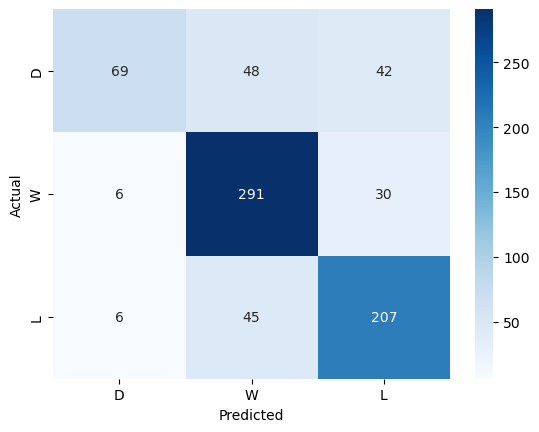

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["D", "W", "L"], yticklabels=["D", "W", "L"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [65]:
from sklearn.metrics import precision_score

precision = precision_score(test["target"], preds, average='weighted', zero_division=1)
print("Precision Score: {:.2f}".format(precision))

Precision Score: 0.77


In [66]:
from sklearn.metrics import f1_score

f1 = f1_score(test["target"], preds, average='weighted')
print("F1 Score: {:.2f}".format(f1))

F1 Score: 0.75


In [67]:
matches.head()

,match_id,season,date_time,team,opponent,stadium,home_team_score,away_team_score,penalty_shoot_out,attendance,result,opp_code,day_code,home_match,target
0,mt1,2021,2021-09-15 20:00:00,Manchester City,RB Leipzig,Etihad Stadium,6,3,0,38062,W,55,2,1,1
1,mt2,2021,2021-09-15 20:00:00,Club Brugge KV,Paris Saint-Germain,Jan Breydel Stadion,1,1,0,27546,D,53,2,1,0
2,mt3,2021,2021-09-28 20:00:00,Paris Saint-Germain,Manchester City,Parc des Princes,2,0,0,37350,W,45,1,1,1
3,mt4,2021,2021-09-28 20:00:00,RB Leipzig,Club Brugge KV,Red Bull Arena,1,2,0,23500,L,19,1,1,2
4,mt5,2021,2021-10-19 17:45:00,Club Brugge KV,Manchester City,Jan Breydel Stadion,1,5,0,24915,L,45,1,1,2


In [68]:
import joblib

filename = 'match_prediction_model_svm_test2.joblib'
joblib.dump(svm, filename)

['match_prediction_model_svm_test2.joblib']